In [244]:
import os
import sys
import numpy as np
import pandas as pd

In [245]:
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import colors
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

In this notebook I will demonstrate how to convert the QCD and top jets from the top tagging challenge (https://arxiv.org/pdf/1902.09914.pdf) into the jet image representation.

This is following the procedure outlined in https://arxiv.org/abs/1808.08979v3 and uses code written by Christof Sauer using code from that project.

Much of this could be re-done using sklearn functions, e.g. the steps putting the image on a grid could be done with KBinsDiscretizer.  For the future maybe.

Defining the max number constituents kept for each jet:

In [2]:
n_constit = 200

The path to the raw data:

In [11]:
h5path = "toptagging_train_short.h5"

Select the jets:

In [168]:
df = pd.read_hdf( h5path, key='table', start=0, stop=10000)

We need the names of the columns in the table so we can select them later:

In [169]:
feat_list =  ["E","PX","PY","PZ"] 
cols = ["{0}_{1}".format(feature,constit) for feature in feat_list for constit in range(n_constit)]

In [170]:
cols[0:10]

['E_0', 'E_1', 'E_2', 'E_3', 'E_4', 'E_5', 'E_6', 'E_7', 'E_8', 'E_9']

Now we re-shape the jet from a list of 4-momentum components to 4 lists, one for each component:

In [171]:
vec4 = np.expand_dims(df[cols],axis=-1).reshape(-1, len(feat_list), n_constit)

In [172]:
vec4.shape

(10000, 4, 200)

If we do this for N jets, the shape is ( N, 4, 200 )

We now want to extract the column telling us whether we have a signal or background event:

In [173]:
isig = df["is_signal_new"]

In [174]:
isig

375    0
377    0
378    0
379    0
380    0
      ..
597    0
598    0
600    0
602    0
603    0
Name: is_signal_new, Length: 10000, dtype: int64

The 0 means we have a background event

We now separate the 4-momentum components of the consituents for all jets:

In [175]:
E  = vec4[:,0,:]
pxs   = vec4[:,1,:]
pys   = vec4[:,2,:]
pzs   = vec4[:,3,:]

In [176]:
print(E.shape)
print(pxs.shape)
print(pys.shape)
print(pzs.shape)

(10000, 200)
(10000, 200)
(10000, 200)
(10000, 200)


Again, for N events we would have ( N, 200 ) where 200 is the number of constituents.

Calculating the pT

In [177]:
pT = np.sqrt( pxs**2 + pys**2 )

In [178]:
print(pT.shape)

(10000, 200)


We now want to calculate the etas and phis, so we define these functions:

In [179]:
# Calculate pseudorapidity of pixel entries
def eta(pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate phi of the pixel entries (in range [-pi,pi])
# phis are returned in radians, np.arctan(0,0)=0 -> zero constituents set to -np.pi
def phi (px, py):
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# Calculate the mass from the 4-momentum
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

Calculate the etas and phis:

In [180]:
etas  = eta(pT,pzs)
phis  = phi(pxs,pys)

In [181]:
print(etas.shape) 
print(phis.shape)

(10000, 200)
(10000, 200)


Now we calculate the kinematics of the whole jets by summing across the constituents:

In [182]:
E_tot = E.sum(axis=1)
px_tot = pxs.sum(axis=1)
py_tot = pys.sum(axis=1)
pz_tot = pzs.sum(axis=1)
j_mass = mass(E_tot, px_tot, py_tot, pz_tot)

In [183]:
print(E_tot.shape)
print(px_tot.shape)
print(py_tot.shape)
print(pz_tot.shape)
print(j_mass.shape)

(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


We can now plot the first two jets, the axis are eta vs phi, and the cells contain the pT:

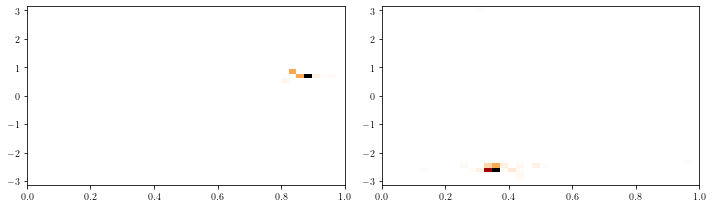

In [184]:
fig, axs = plt.subplots( 1, 2, figsize=(10,3) )
rnge = ( ( 0 , 1 ), ( -np.pi , np.pi ) )
axs[0].hist2d( etas[0], phis[0], weights=pT[0], bins=40, cmap='gist_heat_r', range=rnge )
axs[1].hist2d( etas[1], phis[1], weights=pT[1], bins=40, cmap='gist_heat_r', range=rnge )
fig.tight_layout()

Jets can be produced at any value of phi, so we would like to remove this degenracy from the images.  We do this by first subtracting from the phi component of each constituent of a jet, the phi component of the highest pT component of the jet.  In this way it will be centred at phi=0.

The constituents are pT ordered, so phis[:,0] returns the phi values of the highest pT constituents of each jet:

In [185]:
print(phis[:,0].shape)
print(phis[:,0])

(10000,)
[ 0.72913885 -2.5722082   1.6413395  ...  2.8152578  -1.1202879
  0.3790486 ]


So we want to subtract these for each jet.  Now since this can knock some constituents outside of the [-pi,pi] range we need to being them back in using the fact that phi=+pi = phi=-pi.

In [186]:
phis = (phis.T - phis[:,0]).T
phis[phis < -np.pi] += 2*np.pi
phis[phis > np.pi] -= 2*np.pi

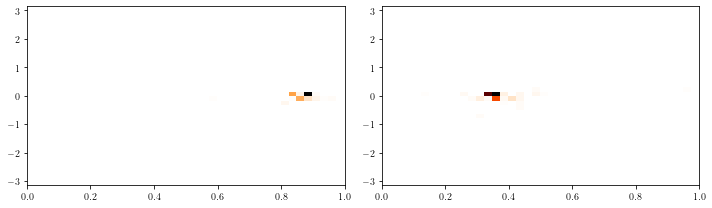

In [187]:
fig, axs = plt.subplots( 1, 2, figsize=(10,3) )
rnge = ( ( 0 , 1 ), ( -np.pi , np.pi ) )
axs[0].hist2d( etas[0], phis[0], weights=pT[0], bins=40, cmap='gist_heat_r', range=rnge )
axs[1].hist2d( etas[1], phis[1], weights=pT[1], bins=40, cmap='gist_heat_r', range=rnge )
fig.tight_layout()

Let's zoom in:

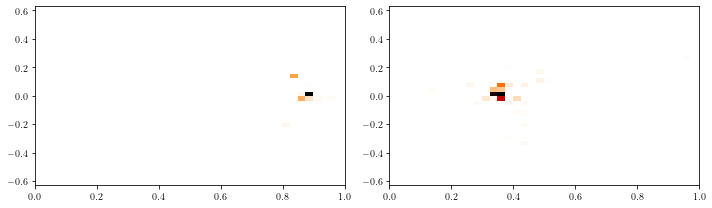

In [188]:
fig, axs = plt.subplots( 1, 2, figsize=(10,3) )
rnge = ( ( 0 , 1 ), ( -np.pi/5 , np.pi/5 ) )
axs[0].hist2d( etas[0], phis[0], weights=pT[0], bins=40, cmap='gist_heat_r', range=rnge )
axs[1].hist2d( etas[1], phis[1], weights=pT[1], bins=40, cmap='gist_heat_r', range=rnge )
fig.tight_layout()

First the centre.  We calculate the centroid in the x (eta) and y (phi) and shift the image so that the centroids are at (x,y)=(0,0).  We use x and y now because we're losing the direct interpretation of these as eta and phi.  There is a general definition of the centroid calculated with the moment of the image, given here:

In [189]:
# returns image momenta for the centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

We then calculate this using the pT rather than the mass as the weight, and centre:

In [190]:
def centre_jet(x, y, weights):
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid
    return x, y

In [191]:
for i in range(vec4.shape[0]):
    etas[i,:], phis[i,:] = centre_jet( etas[i,:], phis[i,:], pT[i,:] )

Now plot again to see the progression:

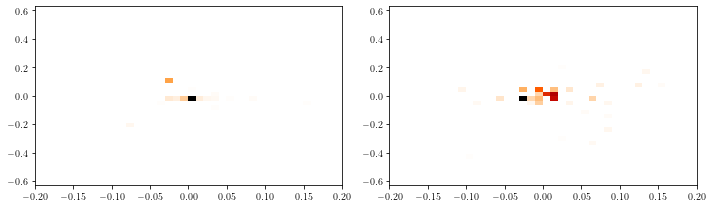

In [192]:
fig, axs = plt.subplots( 1, 2, figsize=(10,3) )
rnge = ( ( -0.2 , 0.2 ), ( -np.pi/5 , np.pi/5 ) )
axs[0].hist2d( etas[0], phis[0], weights=pT[0], bins=40, cmap='gist_heat_r', range=rnge )
axs[1].hist2d( etas[1], phis[1], weights=pT[1], bins=40, cmap='gist_heat_r', range=rnge )
fig.tight_layout()

Next we rotate the jet so that the principle axis points in the direction of increasing pseudo-rapidity (vertically):

In [193]:
def rotate_jet(x, y, weights):
    # Covariant matrix, eigenvectors corr. to principal axis
    u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
    u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
    u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
    cov = np.array([[u20, u11], [u11, u02]])
    # Eigenvalues and eigenvectors of covariant matrix
    evals, evecs = np.linalg.eig(cov)
    # Sorts the eigenvalues, v1, [::-1] turns array around, 
    sort_indices = np.argsort(evals)[::-1]
    e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    e_2 = evecs[:, sort_indices[1]]
    # Theta to x_axis, arctan2 gives correct angle
    theta = np.arctan2(e_1[0], e_1[1])
    # Rotation, so that princple axis is vertical
    # Anti-clockwise rotation matrix
    rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    transformed_mat = rotation * np.stack([x,y])
    x_rot, y_rot = transformed_mat.A
    return x_rot, y_rot

In [194]:
for i in range(vec4.shape[0]):
    etas[i,:], phis[i,:] = rotate_jet( etas[i,:], phis[i,:], pT[i,:] )

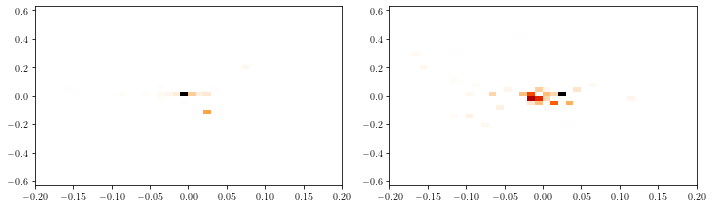

In [195]:
fig, axs = plt.subplots( 1, 2, figsize=(10,3) )
rnge = ( ( -0.2 , 0.2 ), ( -np.pi/5 , np.pi/5 ) )
axs[0].hist2d( etas[0], phis[0], weights=pT[0], bins=40, cmap='gist_heat_r', range=rnge )
axs[1].hist2d( etas[1], phis[1], weights=pT[1], bins=40, cmap='gist_heat_r', range=rnge )
fig.tight_layout()

Lastly we need to flip the jet so that the plane with the most pT is on one side.

In [196]:
def flip_jet(x, y, weights):
    if weights[x<0.].sum() < weights[x>0.].sum():
        x = -x
    if weights[y<0.].sum() > weights[y>0.].sum():
        y = -y
    return x,y 

In [197]:
for i in range(vec4.shape[0]):
    etas[i,:], phis[i,:] = flip_jet( etas[i,:], phis[i,:], pT[i,:] )

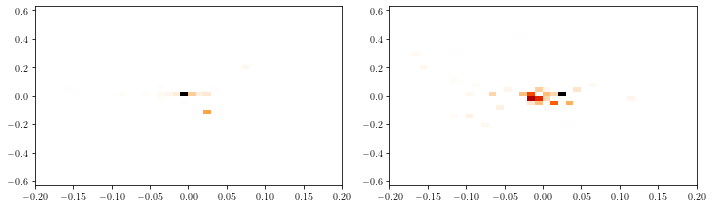

In [198]:
fig, axs = plt.subplots( 1, 2, figsize=(10,3) )
rnge = ( ( -0.2 , 0.2 ), ( -np.pi/5 , np.pi/5 ) )
axs[0].hist2d( etas[0], phis[0], weights=pT[0], bins=40, cmap='gist_heat_r', range=rnge )
axs[1].hist2d( etas[1], phis[1], weights=pT[1], bins=40, cmap='gist_heat_r', range=rnge )
fig.tight_layout()

Now I want to plot a histogram for both of these two jets here:

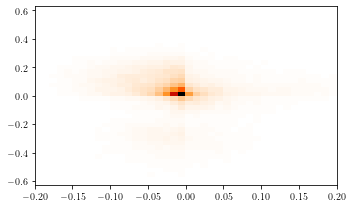

In [213]:
fig, axs = plt.subplots( 1, 1, figsize=(5,3) )
rnge = ( ( -0.2 , 0.2 ), ( -np.pi/5 , np.pi/5 ) )
#axs.hist2d( etas.reshape(-1), phis.reshape(-1), weights=pT.reshape(-1), bins=40, cmap='gist_heat_r', range=rnge, norm=colors.LogNorm() )
axs.hist2d( etas.reshape(-1), phis.reshape(-1), weights=pT.reshape(-1), bins=40, cmap='gist_heat_r', range=rnge )
fig.tight_layout()

The re-shape basically concatenates the constituents for all jets together:

In [200]:
etas.reshape(-1).shape

(2000000,)

This looks odd, but we've averaged over both top and QCD jets, in approximately equal proportions.  So we'll see what it's like at the end once we split it up.

Now we need to create the image and pixelize etc.  We start by defining the grid we're using and a function:

In [214]:
# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

In [273]:
# Put eta-phi entries on grid
def orig_image (etas, phis, es):
    # gives the value on grid with minimal distance,
    # eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    # first define the grid full of zeros
    z = np.zeros( ( etas.shape[0], len(xpixels), len(ypixels) ) )
    # now we want a vector telling us if a point is in the grid
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    # for each eta and phi we now find the cell on the grid that is closest to the actual coordinate
    xcoords = np.argmin( np.abs( etas[:,None,:] - xpixels[None,:,None] ), axis=1 )
    ycoords = np.argmin( np.abs( phis[:,None,:] - ypixels[None,:,None] ), axis=1 )
    # create a grid where each row is filled with the event number
    ncoords = np.repeat( np.arange( etas.shape[0])[:,None], etas.shape[1], axis=1 )
    # create a single array for all images, for each jet there is a 180x180 matrix
    z[ ncoords[in_grid], ycoords[in_grid], xcoords[in_grid] ] = es[in_grid]
    return z

In [228]:
etas[:,None,:].shape

(10000, 1, 200)

In [227]:
xpixels[None,:,None].shape

(1, 180, 1)

In [230]:
( etas[:,None,:] - xpixels[None,:,None] ).shape

(10000, 180, 200)

In [232]:
np.abs( etas[:,None,:] - xpixels[None,:,None] ).shape

(10000, 180, 200)

In [235]:
np.argmin( np.abs(etas[:,None,:] - xpixels[None,:,None] ), axis=1 ).shape

(10000, 200)

In [252]:
np.argmin( np.abs(etas[:,None,:] - xpixels[None,:,None] ), axis=1 )[0]

array([ 89,  91,  89,  90,  89,  90,  90,  90,  90,  89,  92,  88,  87,
        89,  91,  89,  88,  84,  89,  99, 100,  74,  92, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 12

In [236]:
np.repeat( np.arange( etas.shape[0])[:,None], etas.shape[1], axis=1 ).shape

(10000, 200)

In [237]:
np.repeat( np.arange( etas.shape[0])[:,None], etas.shape[1], axis=1 )

array([[   0,    0,    0, ...,    0,    0,    0],
       [   1,    1,    1, ...,    1,    1,    1],
       [   2,    2,    2, ...,    2,    2,    2],
       ...,
       [9997, 9997, 9997, ..., 9997, 9997, 9997],
       [9998, 9998, 9998, ..., 9998, 9998, 9998],
       [9999, 9999, 9999, ..., 9999, 9999, 9999]])

In [247]:
in_grid_p = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
in_grid_p.shape

(10000, 200)

In [248]:
np.repeat( np.arange( etas.shape[0])[:,None], etas.shape[1], axis=1 )[in_grid_p]
np.repeat( np.arange( etas.shape[0])[:,None], etas.shape[1], axis=1 )[in_grid_p].shape

(1882634,)

In [253]:
xcoords_p = np.argmin( np.abs( etas[:,None,:] - xpixels[None,:,None] ), axis=1 )
ycoords_p = np.argmin( np.abs( phis[:,None,:] - ypixels[None,:,None] ), axis=1 )
ncoords_p = np.repeat( np.arange( etas.shape[0])[:,None], etas.shape[1], axis=1 )
z_p = np.zeros( ( etas.shape[0], len(xpixels), len(ypixels) ) )
z_p[ ncoords_p[in_grid_p], ycoords_p[in_grid_p], xcoords_p[in_grid_p] ] = pT[in_grid_p]

In [254]:
z_p.shape

(10000, 180, 180)

So to summarise we create the images:

In [274]:
z_ori = orig_image(etas, phis, pT)

And we can now crop and normalise them:

In [277]:
crop = True
norm = True
n_crop = 40
z_new = np.zeros((z_ori.shape[0],n_crop, n_crop))
for i in range(z_ori.shape[0]):
    if crop:
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2):int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2):int(Npix[1]/2+n_crop/2)]
    else:
        z_new = z_ori
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum

Let's again plot the first two jets:

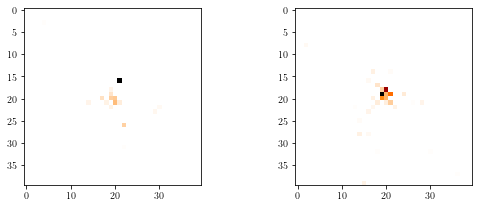

In [282]:
fig, axs = plt.subplots( 1, 2, figsize=(8,3) )
axs[0].imshow( z_new[0], cmap='gist_heat_r' )
axs[1].imshow( z_new[1], cmap='gist_heat_r' )
fig.tight_layout()

And the average of all jets:

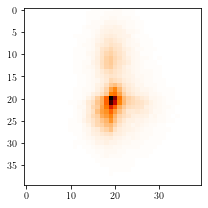

In [290]:
z_ave = z_new[0]
for i in z_new:
    z_ave+=i
fig, axs = plt.subplots( 1, 1, figsize=(8,3) )
axs.imshow( z_ave, cmap='gist_heat_r' )
fig.tight_layout()

And now the average of all QCD (left) and top (right) jets:

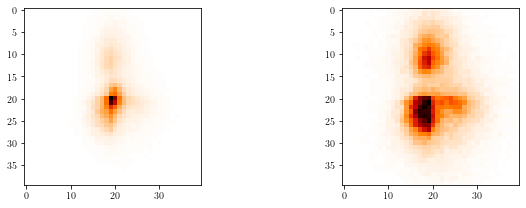

In [299]:
z_qcd_ave = z_new[isig==0][0]
for i in z_new[ isig==0 ]:
    z_qcd_ave+=i
z_top_ave = z_new[isig==1][0]
for i in z_new[ isig==1 ]:
    z_top_ave+=i
fig, axs = plt.subplots( 1, 2, figsize=(10,3) )
axs[0].imshow( z_qcd_ave, cmap='gist_heat_r' )
axs[1].imshow( z_top_ave, cmap='gist_heat_r' )
fig.tight_layout()

In [300]:
len(z_new)

10000

In [301]:
len(z_new[isig==0])

4920

In [302]:
len(z_new[isig==1])

5080

Let's try looking at the energy instead of the pT.

In [303]:
z_ori_E = orig_image(etas, phis, E)

In [304]:
crop = True
norm = True
n_crop = 40
z_new_E = np.zeros((z_ori_E.shape[0],n_crop, n_crop))
for i in range(z_ori.shape[0]):
    if crop:
        Npix = z_ori_E[i,:,:].shape
        z_new_E[i,:,:] = z_ori_E[i, int(Npix[0]/2-n_crop/2):int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2):int(Npix[1]/2+n_crop/2)]
    else:
        z_new_E = z_ori_E
        if norm:
            z_sum = z_new_E[i,:,:].sum()
            if z_sum != 0.:
                z_new_E[i,:,:] = z_new_E[i,:,:]/z_sum

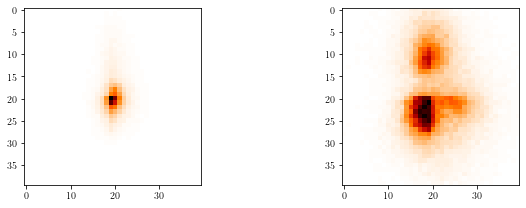

In [305]:
z_qcd_E_ave = z_new_E[isig==0][0]
for i in z_new_E[ isig==0 ]:
    z_qcd_E_ave+=i
z_top_E_ave = z_new_E[isig==1][0]
for i in z_new_E[ isig==1 ]:
    z_top_E_ave+=i
fig, axs = plt.subplots( 1, 2, figsize=(10,3) )
axs[0].imshow( z_qcd_E_ave, cmap='gist_heat_r' )
axs[1].imshow( z_top_E_ave, cmap='gist_heat_r' )
fig.tight_layout()

All of these steps are put together in the constit2img.py script in the repo (again, not written by me).  And here we can choose whether we want the weight (i.e. intensity) to be defined as the energy or the pT of the constituents.

#######################################

#######################################

#######################################

#######################################

Loading the images that have already been generated:

In [306]:
h5path = "toptagging_train_short_crop_rot_flip_norm_pt.h5"
df_pt = pd.read_hdf( h5path, key='table', start=0, stop=10000)
h5path = "toptagging_train_short_crop_rot_flip_norm_E.h5"
df_E = pd.read_hdf( h5path, key='table', start=0, stop=10000)

Sum over all jets for signal and background separately, starting with the images using energy as intensity:

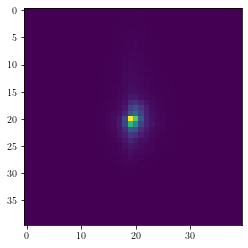

In [427]:
is_sig = df_E["is_signal_new"]
qcd_e_ave = np.zeros( (40,40) )
for i in range( df_E[ is_sig==0 ].T.shape[1] ):
    qcd_e_ave+ = df_E[ is_sig.to_numpy()==0 ].to_numpy()[i][0:1600].reshape( (40,40) )
plt.imshow( qcd_e_ave )

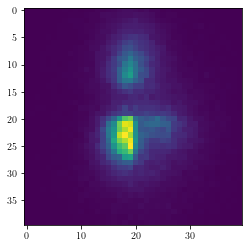

In [428]:
is_sig = df_E["is_signal_new"]
top_e_ave = np.zeros( (40,40) )
for i in range( df_E[ is_sig==1 ].T.shape[1] ):
    top_e_ave += df_E[ is_sig.to_numpy()==1 ].to_numpy()[i][0:1600].reshape( (40,40) )
plt.imshow( top_e_ave )

Produce and save a plot comparing the two:

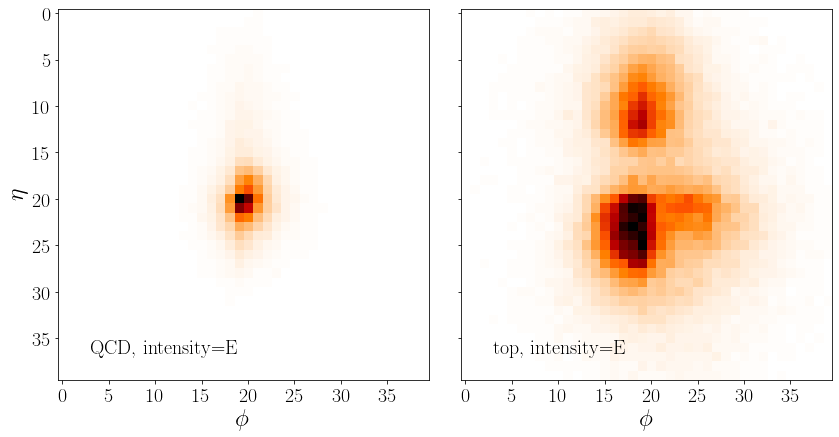

In [483]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
cmap = 'gist_heat_r'

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(20)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(24)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(20)

axisfontsize = 18
labelfontsize = 18
axs[0].imshow( qcd_e_ave, cmap=cmap )
axs[1].imshow( top_e_ave, cmap=cmap )

axs[0].text( 3, 37,  "QCD, intensity=E", va='bottom', ha='left', fontproperties=labelfont )
axs[1].text( 3, 37,  "top, intensity=E", va='bottom', ha='left', fontproperties=labelfont )

axs[0].set_yticks(range(0,40,5))
axs[0].set_yticklabels(range(0,40,5), fontproperties=tickfont )
axs[0].set_xticks(range(0,40,5))
axs[0].set_xticklabels(range(0,40,5), fontproperties=tickfont )
axs[1].set_xticks(range(0,40,5))
axs[1].set_xticklabels(range(0,40,5), fontproperties=tickfont )
axs[1].set_yticklabels([])

axs[0].set_xlabel("$\phi$", fontproperties=axislabelfont)
axs[1].set_xlabel("$\phi$", fontproperties=axislabelfont)
axs[0].set_ylabel("$\eta$", fontproperties=axislabelfont)

fig.tight_layout()

#fig.savefig("qcd_top_ave_jet_images_inE.pdf", bbox_inches = "tight")
#fig.show()

Now do the same for the images using the pt as the intensity:

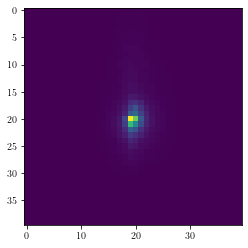

In [477]:
is_sig = df_pt["is_signal_new"]
qcd_pt_ave = np.zeros( (40,40) )
for i in range( df_pt[ is_sig==0 ].T.shape[1] ):
    qcd_pt_ave += df_pt[ is_sig.to_numpy()==0 ].to_numpy()[i][0:1600].reshape( (40,40) )
plt.imshow( qcd_pt_ave )

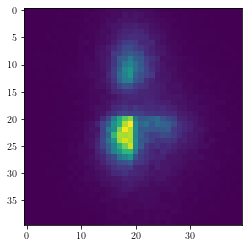

In [478]:
is_sig = df_pt["is_signal_new"]
top_pt_ave = np.zeros( (40,40) )
for i in range( df_pt[ is_sig==1 ].T.shape[1] ):
    top_pt_ave += df_pt[ is_sig.to_numpy()==1 ].to_numpy()[i][0:1600].reshape( (40,40) )
plt.imshow( top_pt_ave )

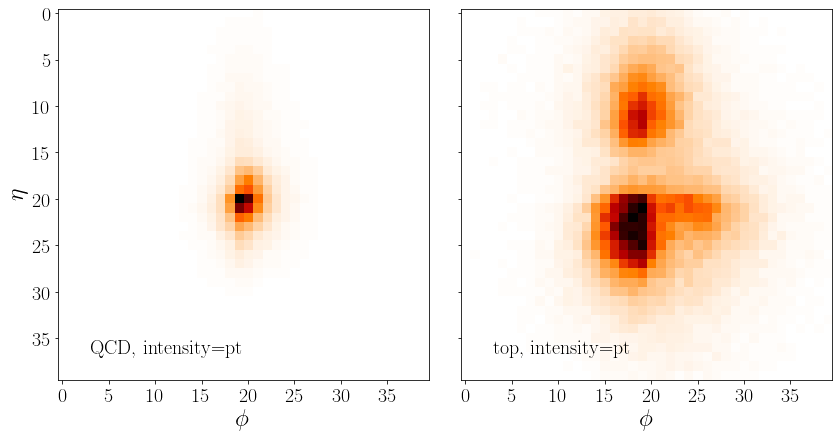

In [482]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
cmap = 'gist_heat_r'

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(20)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(24)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(20)

axisfontsize = 18
labelfontsize = 18
axs[0].imshow( qcd_pt_ave, cmap=cmap )
axs[1].imshow( top_pt_ave, cmap=cmap )

axs[0].text( 3, 37,  "QCD, intensity=pt", va='bottom', ha='left', fontproperties=labelfont )
axs[1].text( 3, 37,  "top, intensity=pt", va='bottom', ha='left', fontproperties=labelfont )

axs[0].set_yticks(range(0,40,5))
axs[0].set_yticklabels(range(0,40,5), fontproperties=tickfont )
axs[0].set_xticks(range(0,40,5))
axs[0].set_xticklabels(range(0,40,5), fontproperties=tickfont )
axs[1].set_xticks(range(0,40,5))
axs[1].set_xticklabels(range(0,40,5), fontproperties=tickfont )
axs[1].set_yticklabels([])

axs[0].set_xlabel("$\phi$", fontproperties=axislabelfont)
axs[1].set_xlabel("$\phi$", fontproperties=axislabelfont)
axs[0].set_ylabel("$\eta$", fontproperties=axislabelfont)

fig.tight_layout()

#fig.savefig("qcd_top_ave_jet_images_inpt.pdf", bbox_inches = "tight")
#fig.show()

For an individual jet from QCD and tops we have:

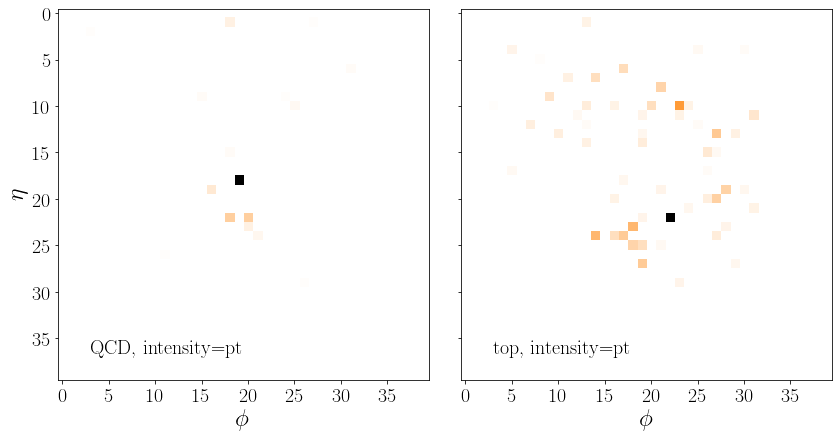

In [484]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
cmap = 'gist_heat_r'

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(20)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(24)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(20)

axisfontsize = 18
labelfontsize = 18
axs[0].imshow( df_pt[ is_sig.to_numpy()==0 ].to_numpy()[0][0:1600].reshape( (40,40) ), cmap=cmap )
axs[1].imshow( df_pt[ is_sig.to_numpy()==1 ].to_numpy()[0][0:1600].reshape( (40,40) ), cmap=cmap )

axs[0].text( 3, 37,  "QCD, intensity=pt", va='bottom', ha='left', fontproperties=labelfont )
axs[1].text( 3, 37,  "top, intensity=pt", va='bottom', ha='left', fontproperties=labelfont )

axs[0].set_yticks(range(0,40,5))
axs[0].set_yticklabels(range(0,40,5), fontproperties=tickfont )
axs[0].set_xticks(range(0,40,5))
axs[0].set_xticklabels(range(0,40,5), fontproperties=tickfont )
axs[1].set_xticks(range(0,40,5))
axs[1].set_xticklabels(range(0,40,5), fontproperties=tickfont )
axs[1].set_yticklabels([])

axs[0].set_xlabel("$\phi$", fontproperties=axislabelfont)
axs[1].set_xlabel("$\phi$", fontproperties=axislabelfont)
axs[0].set_ylabel("$\eta$", fontproperties=axislabelfont)

fig.tight_layout()

#fig.savefig("qcd_top_ave_single_jet_images_inpt.pdf", bbox_inches = "tight")
#fig.show()